### Name - Abhishek Kardam

# Lazy Pipeline

In [1]:
import pandas as pd
import pipeline as lpipe

In [2]:
df = lpipe.load_data('cars')
print(df.columns)
print(df.shape)
df.head()

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'], dtype='object')
(1727, 7)


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,False
1,vhigh,vhigh,2,2,small,high,False
2,vhigh,vhigh,2,2,med,low,False
3,vhigh,vhigh,2,2,med,med,False
4,vhigh,vhigh,2,2,med,high,False


In [3]:
y_name = 'class'
y = df[y_name]
X = lpipe.binarize_X(df.drop(y_name, axis=1))
print('y_shape: ', y.shape)
print('X_shape: ', X.shape)
X.head

y_shape:  (1727,)
X_shape:  (1727, 21)


<bound method NDFrame.head of       buying: high  buying: low  buying: med  buying: vhigh  maint: high  \
0            False        False        False           True        False   
1            False        False        False           True        False   
2            False        False        False           True        False   
3            False        False        False           True        False   
4            False        False        False           True        False   
...            ...          ...          ...            ...          ...   
1722         False         True        False          False        False   
1723         False         True        False          False        False   
1724         False         True        False          False        False   
1725         False         True        False          False        False   
1726         False         True        False          False        False   

      maint: low  maint: med  maint: vhigh  doors: 2  doo

In [4]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

In [5]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[:1]

[{'buying: high',
  'doors: 4',
  'lug_boot: big',
  'maint: high',
  'persons: 2',
  'safety: low'}]

In [6]:
n_train = int(len(X)*0.9)
n_test = len(X) - n_train
print('n_train: ', n_train)
print('n_test: ', n_test)

n_train:  1554
n_test:  173


In [7]:
%%time
gen = lpipe.predict_array(X_bin, y.values.tolist(), n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|█████████████████████████████████████████████████████| 1727/1727 [00:16<00:00, 10.43it/s]

CPU times: total: 15.6 s
Wall time: 16.6 s


In [8]:
%%time
gen = list(lpipe.predict_array(X_bin, y.values.tolist(), n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|█████████████████████████████████████████████████████| 1727/1727 [00:15<00:00, 10.85it/s]

CPU times: total: 15.8 s
Wall time: 16 s


In [9]:
y_test = y[n_train:]

In [10]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
#    print(score_name)
    preds = y_preds
    if score_name == 'accuracy_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i], average='weighted') for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    if score_name == 'accuracy_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i], average='weighted') for i in range(1, len(preds))]
    
print ("Accuracy : ", accuracy_score(y_test,y_preds)*100)
print("F1-score: ", f1_score(y_test, y_preds) * 100)

Accuracy :  92.48554913294798
F1-score:  0.0


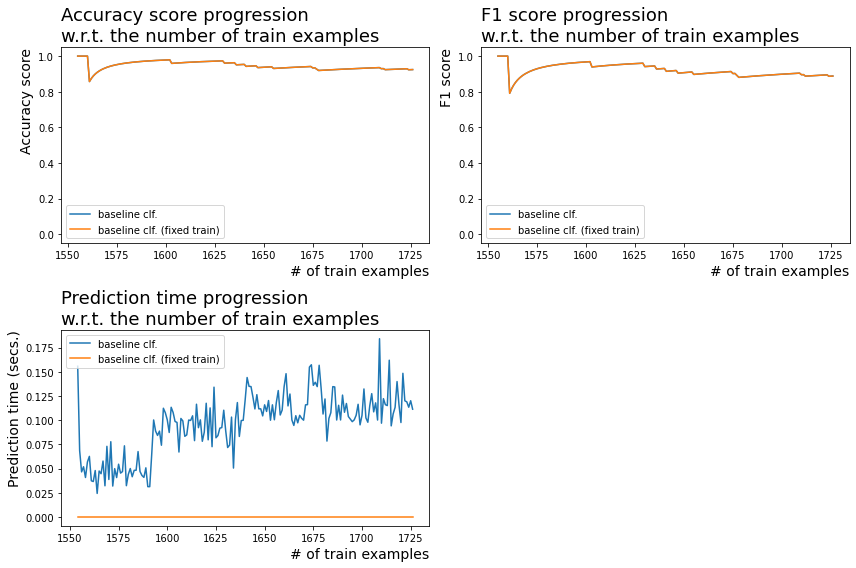

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score','Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()

# KNN Pipeline

In [1]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import KNN_pipeline as kpipe

In [2]:
df = kpipe.load_data('cars')
print(df.columns)
print(df.shape)
df.head()

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'], dtype='object')
(1727, 7)


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,False
1,vhigh,vhigh,2,2,small,high,False
2,vhigh,vhigh,2,2,med,low,False
3,vhigh,vhigh,2,2,med,med,False
4,vhigh,vhigh,2,2,med,high,False


In [3]:
y_name = 'class'
y = df[y_name]
X = kpipe.binarize_X(df.drop(y_name, axis=1))
print('y_shape: ', y.shape)
print('X_shape: ', X.shape)
X.head()

y_shape:  (1727,)
X_shape:  (1727, 21)


,buying: high,buying: low,buying: med,buying: vhigh,maint: high,maint: low,maint: med,maint: vhigh,doors: 2,doors: 3,...,doors: 5more,persons: 2,persons: 4,persons: more,lug_boot: big,lug_boot: med,lug_boot: small,safety: high,safety: low,safety: med
0,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,False,True,False,False,True
1,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,False,True,True,False,False
2,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,True,False,False,True,False
3,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,True,False,False,False,True
4,False,False,False,True,False,False,False,True,True,False,...,False,True,False,False,False,True,False,True,False,False


In [4]:
import numpy
X = numpy.multiply(X, 1)
X.head()

,buying: high,buying: low,buying: med,buying: vhigh,maint: high,maint: low,maint: med,maint: vhigh,doors: 2,doors: 3,...,doors: 5more,persons: 2,persons: 4,persons: more,lug_boot: big,lug_boot: med,lug_boot: small,safety: high,safety: low,safety: med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0


In [5]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

In [6]:
n_train = int(len(X)*0.9)
n_test = len(X) - n_train
print('n_train: ', n_train)
print('n_test: ', n_test)

n_train:  1554
n_test:  173


In [7]:
%%time
gen = kpipe.predict_array(X, y.values.tolist(), n_train, use_tqdm=True)
y_preds, t_preds = kpipe.apply_stopwatch(gen)


Predicting step by step: 100%|█████████████████████████████████████████████████████| 1727/1727 [01:01<00:00,  2.81it/s]

CPU times: total: 1min 2s
Wall time: 1min 1s


In [8]:
%%time
gen = list(kpipe.predict_array(X, y.values.tolist(), n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = kpipe.apply_stopwatch(gen)

Predicting step by step: 100%|█████████████████████████████████████████████████████| 1727/1727 [01:02<00:00,  2.78it/s]

CPU times: total: 1min 1s
Wall time: 1min 2s


In [9]:
y_test = y[n_train:]

In [10]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
#    print(score_name)
    preds = y_preds
    if score_name == 'accuracy_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i], average='weighted') for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    if score_name == 'accuracy_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i], average='weighted') for i in range(1, len(preds))]
    
print ("Accuracy : ", accuracy_score(y_test,y_preds)*100)
print("F1-score: ", f1_score(y_test, y_preds) * 100)

Accuracy :  96.53179190751445
F1-score:  72.72727272727273


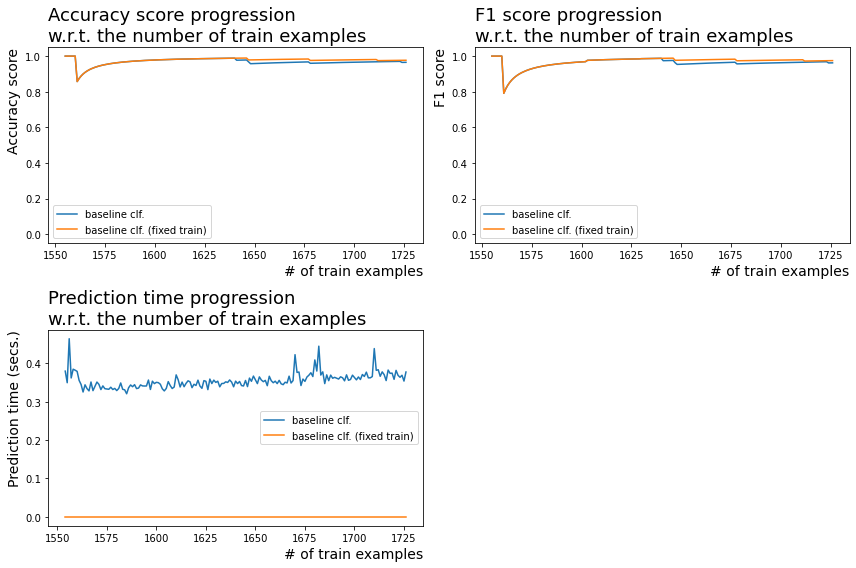

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score','Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()

# Decision Tree

In [12]:
# Run this program on your local python
# interpreter, provided you have installed
# the required libraries.

# Importing the required packages
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

import pipeline as lpipe

# Function to perform training with giniIndex.
def train_using_gini(X_train, X_test, y_train):

    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 100,max_depth=3, min_samples_leaf=5)

    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini

# Function to make predictions
def prediction(X_test, clf_object):

    # Predicton on test with giniIndex
    y_pred = clf_object.predict(X_test)
    return y_pred
    
# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
    print ("Accuracy : ",accuracy_score(y_test,y_pred)*100)
    print("F1-score: ", f1_score(y_test, y_pred) * 100)

# Driver code
def main():
    
    df = lpipe.load_data('cars')
    print(df.columns)
    print(df.shape)
    df.head()

    y_name = 'class'
    y = df[y_name]
    
    X = lpipe.binarize_X(df.drop(y_name, axis=1))

    X = X.sample(frac=1, random_state=42)  # Shuffle X
    y = y[X.index]  # Order y to follow the order of rows from X

    n_train = int(len(X)*0.1)
    n_test = len(X) - n_train
    X_train = X[:n_train]
    X_test = X[n_train:]
    y_train = y[:n_train]
    y_test = y[n_train:]

    
    clf_gini = train_using_gini(X_train, X_test, y_train)
    
    # Operational Phase
    # Prediction using gini
    y_pred_gini = prediction(X_test, clf_gini)
    cal_accuracy(y_test, y_pred_gini)
    
    
# Calling main function
if __name__=="__main__":
    main()


Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'], dtype='object')
(1727, 7)
Accuracy :  92.47588424437299
F1-score:  26.41509433962264


# Random Forest

In [13]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pipeline as lpipe

df = lpipe.load_data('cars')
print(df.columns)
print(df.shape)
df.head()

y_name = 'class'
y = df[y_name]
    
X = lpipe.binarize_X(df.drop(y_name, axis=1))

X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X


n_train = int(len(X)*0.1)
n_test = len(X) - n_train
X_train = X[:n_train]
X_test = X[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]
    
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred) * 100)
print("F1-score: ", metrics.f1_score(y_test, y_pred) * 100)

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'], dtype='object')
(1727, 7)
Accuracy:  94.34083601286174
F1-score:  46.34146341463415


# More datasets

## Thoraric Surgery Dataset

In [14]:
import pandas as pd
import pipeline as lpipe

In [15]:
df = lpipe.load_data('ThoraricSurgery')
print(df.columns)
print(df.shape)
df.head()


Index(['DGN', 'PRE4', 'PRE5', 'PRE6', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11',
       'PRE14', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32', 'AGE', 'class'],
      dtype='object')
(469, 17)


,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,class
0,DGN3,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51,False
1,DGN3,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59,False
2,DGN3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54,False
3,DGN3,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73,True
4,DGN3,2.48,1.88,PRZ1,F,F,F,T,F,OC11,F,F,F,F,F,51,False


In [16]:
y_name = 'class'
y = df[y_name]
X = lpipe.binarize_X(df.drop(y_name, axis=1))
print('y_shape: ', y.shape)
print('X_shape: ', X.shape)
X.head()


y_shape:  (469,)
X_shape:  (469, 349)


,DGN: DGN1,DGN: DGN2,DGN: DGN3,DGN: DGN4,DGN: DGN5,DGN: DGN6,DGN: DGN8,PRE4: 1.44,PRE4: 1.46,PRE4: 1.7,...,AGE: 73,AGE: 74,AGE: 75,AGE: 76,AGE: 77,AGE: 78,AGE: 79,AGE: 80,AGE: 81,AGE: 87
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
X = X.sample(frac=1)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X


In [23]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[:1]

[{'AGE: 66',
  'DGN: DGN3',
  'PRE10: T',
  'PRE11: F',
  'PRE14: OC11',
  'PRE17: F',
  'PRE19: F',
  'PRE25: F',
  'PRE30: T',
  'PRE32: F',
  'PRE4: 3.88',
  'PRE5: 2.84',
  'PRE6: PRZ1',
  'PRE7: F',
  'PRE8: T',
  'PRE9: F'}]

In [24]:
n_train = int(len(X)*0.9)
n_test = len(X) - n_train
print('n_train: ', n_train)
print('n_test: ', n_test)

n_train:  422
n_test:  47


In [25]:
%%time
gen = lpipe.predict_array(X_bin, y.values.tolist(), n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|███████████████████████████████████████████████████████| 469/469 [00:02<00:00, 21.92it/s]

CPU times: total: 2.12 s
Wall time: 2.15 s


In [26]:
%%time
gen = list(lpipe.predict_array(X_bin, y.values.tolist(), n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|███████████████████████████████████████████████████████| 469/469 [00:01<00:00, 24.09it/s]

CPU times: total: 1.92 s
Wall time: 1.96 s


In [27]:
y_test = y[n_train:]

In [28]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
#    print(score_name)
    preds = y_preds
    if score_name == 'accuracy_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i], average='weighted') for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    if score_name == 'accuracy_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i], average='weighted') for i in range(1, len(preds))]
    
print ("Accuracy : ", accuracy_score(y_test,y_preds)*100)
print("F1-score: ", f1_score(y_test, y_preds, average='weighted') * 100)

Accuracy :  95.74468085106383
F1-score:  93.66327474560592


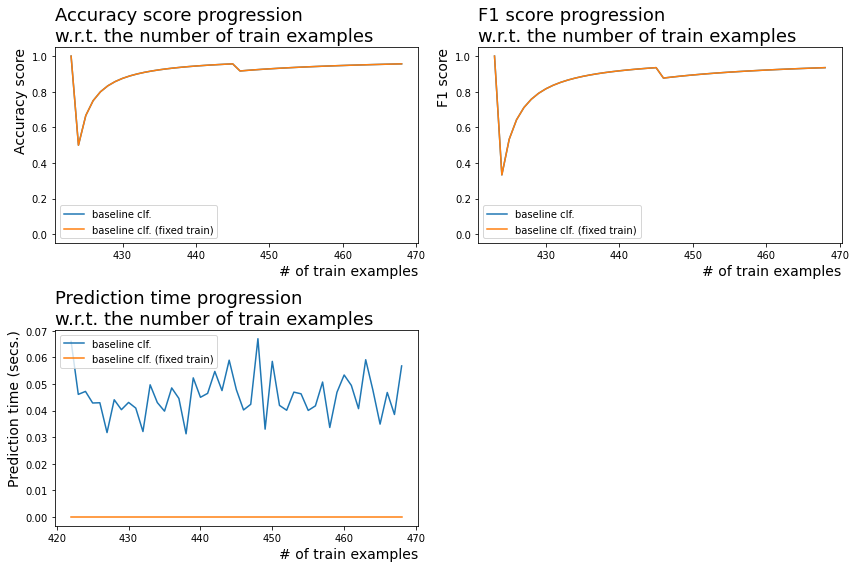

In [29]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score','Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()

## seismic bumps Dataset

In [1]:
import pandas as pd
import pipeline as lpipe

In [2]:
df = lpipe.load_data('seismic-bumps')
print(df.columns)
print(df.shape)
df.head()


Index(['seismic', 'seismoacoustic', 'shift', 'genergy', 'gpuls', 'gdenergy',
       'gdpuls', 'ghazard', 'nbumps', 'nbumps2', 'nbumps3', 'nbumps4',
       'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89', 'energy', 'maxenergy',
       'class'],
      dtype='object')
(2583, 19)


,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,False
1,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,False
2,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,False
3,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,False
4,a,a,W,63760,195,-73,-65,a,0,0,0,0,0,0,0,0,0,0,False


In [3]:
y_name = 'class'
y = df[y_name]
X = lpipe.binarize_X(df.drop(y_name, axis=1))
print('y_shape: ', y.shape)
print('X_shape: ', X.shape)
X.head()


y_shape:  (2583,)
X_shape:  (2583, 4284)


,seismic: a,seismic: b,seismoacoustic: a,seismoacoustic: b,seismoacoustic: c,shift: N,shift: W,genergy: 100,genergy: 290,genergy: 340,...,maxenergy: 40000,maxenergy: 50000,maxenergy: 60000,maxenergy: 70000,maxenergy: 80000,maxenergy: 90000,maxenergy: 100000,maxenergy: 200000,maxenergy: 300000,maxenergy: 400000
0,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X


In [5]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[:1]

[{'energy: 2000',
  'gdenergy: 3',
  'gdpuls: -13',
  'genergy: 28570',
  'ghazard: a',
  'gpuls: 336',
  'maxenergy: 2000',
  'nbumps2: 0',
  'nbumps3: 1',
  'nbumps4: 0',
  'nbumps5: 0',
  'nbumps6: 0',
  'nbumps7: 0',
  'nbumps89: 0',
  'nbumps: 1',
  'seismic: a',
  'seismoacoustic: a',
  'shift: W'}]

In [6]:
n_train = int(len(X)*0.9)
n_test = len(X) - n_train
print('n_train: ', n_train)
print('n_test: ', n_test)

n_train:  2324
n_test:  259


In [7]:
%%time
gen = lpipe.predict_array(X_bin, y.values.tolist(), n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|█████████████████████████████████████████████████████| 2583/2583 [02:47<00:00,  1.54it/s]

CPU times: total: 2min 42s
Wall time: 2min 47s


In [8]:
%%time
gen = list(lpipe.predict_array(X_bin, y.values.tolist(), n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|█████████████████████████████████████████████████████| 2583/2583 [02:33<00:00,  1.69it/s]

CPU times: total: 2min 28s
Wall time: 2min 33s


In [9]:
y_test = y[n_train:]

In [10]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
#    print(score_name)
    preds = y_preds
    if score_name == 'accuracy_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i], average='weighted') for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    if score_name == 'accuracy_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i], average='weighted') for i in range(1, len(preds))]
    
print ("Accuracy : ", accuracy_score(y_test,y_preds)*100)
print("F1-score: ", f1_score(y_test, y_preds, average='weighted') * 100)

Accuracy :  95.36679536679536
F1-score:  93.10513223556701


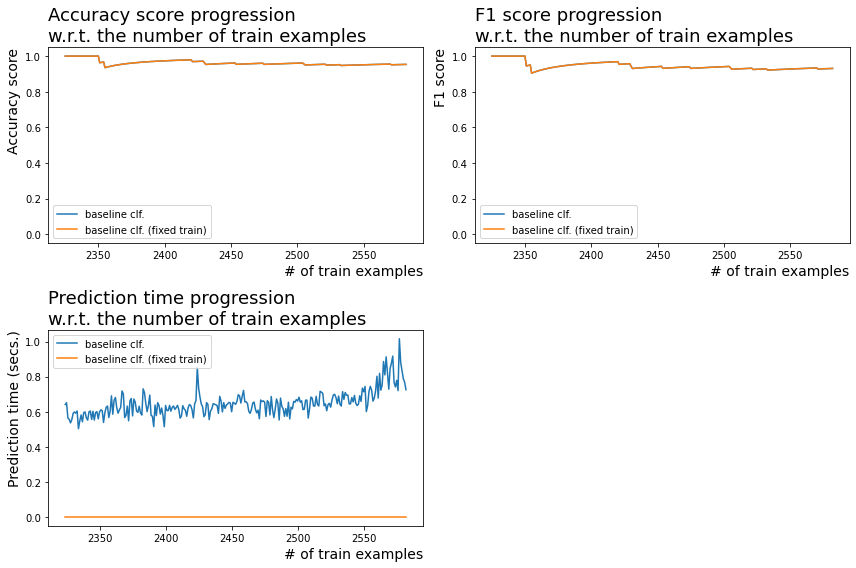

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score','Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()

## Breast Cancer Dataset

In [1]:
import pandas as pd
import pipeline as lpipe

In [2]:
df = lpipe.load_data('Breast_Cancer')
print(df.columns)
print(df.shape)
df.head()

Index(['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin',
       'Resistin', 'MCP.1', 'class'],
      dtype='object')
(116, 10)


,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,class
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,True
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,True
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,True
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,True
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,True


In [3]:
y_name = 'class'
y = df[y_name]
X = lpipe.binarize_X(df.drop(y_name, axis=1))
print('y_shape: ', y.shape)
print('X_shape: ', X.shape)
X.head()


y_shape:  (116,)
X_shape:  (116, 900)


,Age: 24,Age: 25,Age: 28,Age: 29,Age: 32,Age: 34,Age: 35,Age: 36,Age: 38,Age: 40,...,MCP.1: 923.886,MCP.1: 928.22,MCP.1: 960.246,MCP.1: 994.316,MCP.1: 1041.843,MCP.1: 1078.359,MCP.1: 1102.11,MCP.1: 1227.91,MCP.1: 1256.083,MCP.1: 1698.44
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X


In [6]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[:1]

[{'Adiponectin: 5.4861',
  'Age: 71',
  'BMI: 25.51020408',
  'Glucose: 112',
  'HOMA: 2.871792',
  'Insulin: 10.395',
  'Leptin: 19.0653',
  'MCP.1: 799.898',
  'Resistin: 42.7447'}]

In [7]:
n_train = int(len(X)*0.1)
n_test = len(X) - n_train
print('n_train: ', n_train)
print('n_test: ', n_test)

n_train:  11
n_test:  105


In [8]:
%%time
gen = lpipe.predict_array(X_bin, y.values.tolist(), n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|████████████████████████████████████████████████████| 116/116 [00:00<00:00, 15074.51it/s]

CPU times: total: 15.6 ms
Wall time: 23.2 ms


In [9]:
%%time
gen = list(lpipe.predict_array(X_bin, y.values.tolist(), n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|████████████████████████████████████████████████████| 116/116 [00:00<00:00, 74682.37it/s]

CPU times: total: 0 ns
Wall time: 4.96 ms


In [10]:
y_test = y[n_train:]

In [11]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
#    print(score_name)
    preds = y_preds
    if score_name == 'accuracy_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    if score_name == 'accuracy_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
print ("Accuracy : ", accuracy_score(y_test,y_preds)*100)
print("F1-score: ", f1_score(y_test, y_preds) * 100)

Accuracy :  57.14285714285714
F1-score:  15.09433962264151


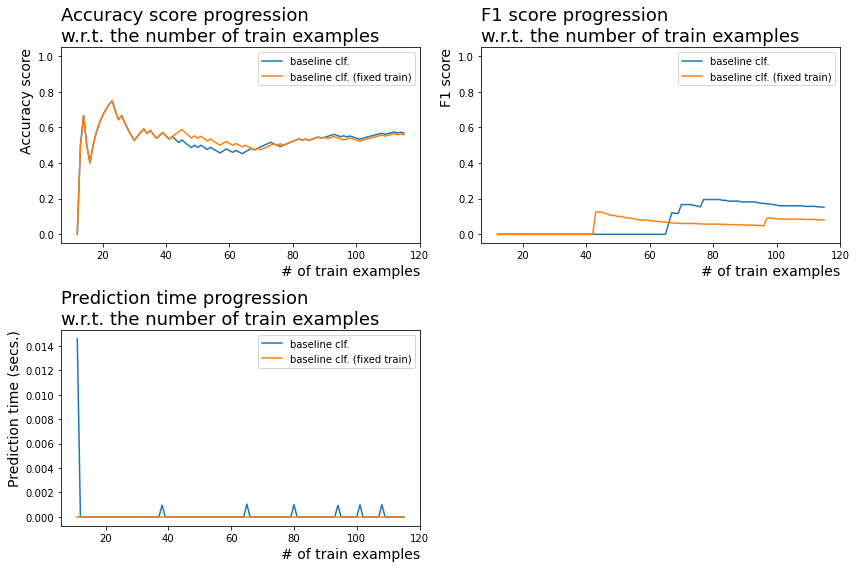

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score','Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()